In [35]:
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# machine learning stack
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder
)
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# time-related stack
from datetime import datetime as dt

# miscellaneous
import warnings
warnings.filterwarnings("ignore")

In [36]:
def qcd_variance(series,window=12):
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    # first quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    # third quartile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    # quartile coefficient of dispersion 
    qcd = round((Q3-Q1)/(Q3+Q1),6)
    
    print(f"quartile coefficient of dispersion: {qcd}")

In [37]:
df = pd.read_csv('data/daily_gold_rate.csv')

In [38]:
df.head()

,Date,USD,EUR,GBP,INR,AED,CNY
0,1/1/1985,308.30,402.45,266.01,3825.85,1134.42,NaN
1,1/2/1985,305.50,401.49,266.00,3787.05,1134.42,NaN
2,1/3/1985,302.30,397.08,262.76,3718.88,1107.67,NaN
3,1/4/1985,303.15,397.15,262.58,3759.64,1118.21,NaN
4,1/7/1985,298.25,392.55,261.17,3741.23,1091.58,835.8


In [39]:
df.set_index(df['Date'],inplace=True)

In [40]:
df

,Date,USD,EUR,GBP,INR,AED,CNY
Date,,,,,,,
1/1/1985,1/1/1985,308.30,402.45,266.01,3825.85,1134.42,NaN
1/2/1985,1/2/1985,305.50,401.49,266.00,3787.05,1134.42,NaN
1/3/1985,1/3/1985,302.30,397.08,262.76,3718.88,1107.67,NaN
1/4/1985,1/4/1985,303.15,397.15,262.58,3759.64,1118.21,NaN
1/7/1985,1/7/1985,298.25,392.55,261.17,3741.23,1091.58,835.80
...,...,...,...,...,...,...,...
10/2/2023,10/2/2023,1833.05,1747.59,1513.92,152333.60,6732.79,13377.60
10/3/2023,10/3/2023,1822.45,1741.97,1509.28,151684.52,6693.86,13300.24
10/4/2023,10/4/2023,1818.95,1730.36,1496.83,151375.75,6680.82,13274.70


In [41]:
df['Date'] = pd.to_datetime(df['Date'])


In [42]:
df = df.dropna()

In [43]:
df

,Date,USD,EUR,GBP,INR,AED,CNY
Date,,,,,,,
1/7/1985,1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.80
1/8/1985,1985-01-08,302.00,395.32,263.07,3820.70,1114.06,853.01
1/9/1985,1985-01-09,300.50,393.54,263.14,3742.23,1097.47,840.31
1/10/1985,1985-01-10,303.80,397.63,268.02,3853.39,1126.83,862.79
1/11/1985,1985-01-11,304.25,398.60,270.57,3845.57,1135.85,869.69
...,...,...,...,...,...,...,...
10/2/2023,2023-10-02,1833.05,1747.59,1513.92,152333.60,6732.79,13377.60
10/3/2023,2023-10-03,1822.45,1741.97,1509.28,151684.52,6693.86,13300.24
10/4/2023,2023-10-04,1818.95,1730.36,1496.83,151375.75,6680.82,13274.70


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10110 entries, 1/7/1985 to 10/6/2023
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10110 non-null  datetime64[ns]
 1   USD     10110 non-null  float64       
 2   EUR     10110 non-null  float64       
 3   GBP     10110 non-null  float64       
 4   INR     10110 non-null  float64       
 5   AED     10110 non-null  float64       
 6   CNY     10110 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 631.9+ KB


In [45]:
df.isnull().sum()

Date    0
USD     0
EUR     0
GBP     0
INR     0
AED     0
CNY     0
dtype: int64

In [46]:
df.set_index('Date', inplace=True)

# Train-Test Split

In [47]:
df['year']=df.index.year

In [48]:
train = df.loc[df.year <= 2015] 
test = df.loc[df.year > 2015]
test

,USD,EUR,GBP,INR,AED,CNY,year
Date,,,,,,,
2016-01-01,1060.00,971.50,714.96,70437.53,3893.38,6881.52,2016
2016-01-04,1082.25,1000.42,736.37,72052.63,3975.10,7068.50,2016
2016-01-05,1077.00,1002.23,734.55,71576.56,3955.82,7024.30,2016
2016-01-06,1091.40,1014.78,746.46,72966.64,4008.71,7147.58,2016
2016-01-07,1106.35,1018.55,758.45,73790.78,4063.62,7297.37,2016
...,...,...,...,...,...,...,...
2023-10-02,1833.05,1747.59,1513.92,152333.60,6732.79,13377.60,2023
2023-10-03,1822.45,1741.97,1509.28,151684.52,6693.86,13300.24,2023
2023-10-04,1818.95,1730.36,1496.83,151375.75,6680.82,13274.70,2023


In [49]:
df

,USD,EUR,GBP,INR,AED,CNY,year
Date,,,,,,,
1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.80,1985
1985-01-08,302.00,395.32,263.07,3820.70,1114.06,853.01,1985
1985-01-09,300.50,393.54,263.14,3742.23,1097.47,840.31,1985
1985-01-10,303.80,397.63,268.02,3853.39,1126.83,862.79,1985
1985-01-11,304.25,398.60,270.57,3845.57,1135.85,869.69,1985
...,...,...,...,...,...,...,...
2023-10-02,1833.05,1747.59,1513.92,152333.60,6732.79,13377.60,2023
2023-10-03,1822.45,1741.97,1509.28,151684.52,6693.86,13300.24,2023
2023-10-04,1818.95,1730.36,1496.83,151375.75,6680.82,13274.70,2023


In [50]:
1985 + 0.8*(2023-1985)

# test = df[df.index.month == 12]

2015.4

In [51]:
train.shape

(8084, 7)

In [52]:
train.shape
test.shape

(2026, 7)

# Model trend

In [53]:
train['time_index'] = np.arange(len(train))


In [54]:
X_train = train[['time_index']]
y_train = train['USD']

In [55]:
X_trend = train[['time_index']]
y_trend = train['USD']


Build trend model

In [56]:
trend_model = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

In [57]:
trend_model.fit(X_trend,y_trend)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

predict from model

In [58]:
train['trend'] = trend_model.predict(X_trend)

In [59]:
train

,USD,EUR,GBP,INR,AED,CNY,year,time_index,trend
Date,,,,,,,,,
1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.80,1985,0,530.237229
1985-01-08,302.00,395.32,263.07,3820.70,1114.06,853.01,1985,1,530.026504
1985-01-09,300.50,393.54,263.14,3742.23,1097.47,840.31,1985,2,529.815866
1985-01-10,303.80,397.63,268.02,3853.39,1126.83,862.79,1985,3,529.605313
1985-01-11,304.25,398.60,270.57,3845.57,1135.85,869.69,1985,4,529.394846
...,...,...,...,...,...,...,...,...,...
2015-12-25,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8079,1626.517099
2015-12-28,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8080,1626.999299
2015-12-29,1070.10,978.87,722.70,70925.69,3930.48,6936.07,2015,8081,1627.481585


plot predicted and original trends

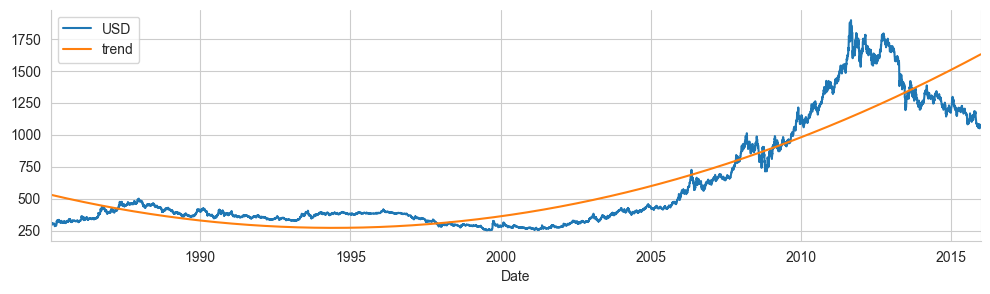

In [60]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['USD','trend']].plot(legend=True)
sns.despine()

In [61]:
train['detrended'] = train['USD'] - train['trend']

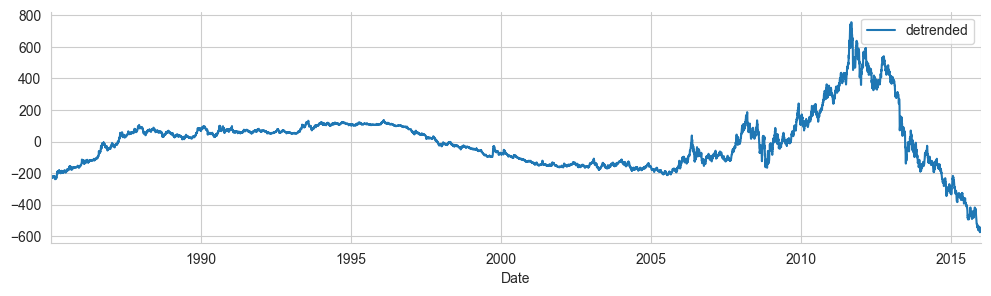

In [62]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['detrended'].plot(legend=True)
sns.despine()

In [63]:
train['month'] = train.index.month

In [64]:
X_seasonality = train[['month']]
y_seasonality = train['detrended']

In [65]:
seasonality_model = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)

In [66]:
seasonality_model.fit(X_seasonality, y_seasonality)

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop='first')),
                ('linearregression', LinearRegression())])

In [67]:
train['seasonality'] = seasonality_model.predict(X_seasonality)

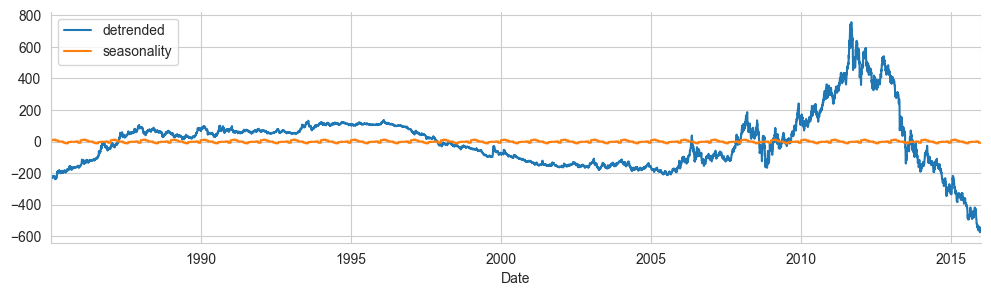

In [68]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['detrended','seasonality']].plot(legend=True)
sns.despine()

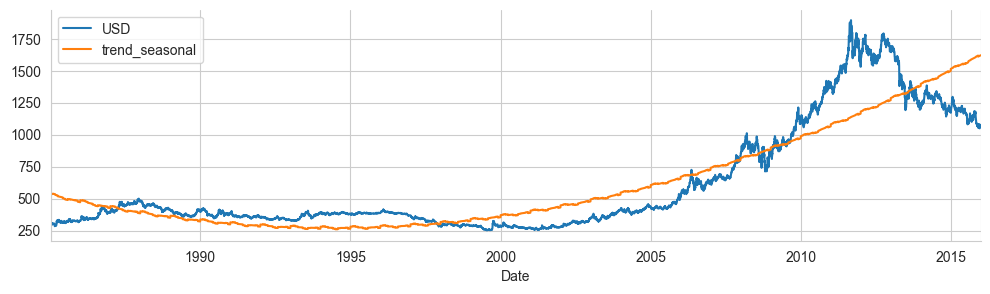

In [69]:
train['trend_seasonal'] = train['trend'] + train['seasonality']

mpl.rc('figure',figsize=(12,3),dpi=100)
train[['USD','trend_seasonal']].plot(legend=True)
sns.despine()

In [70]:
train['remainder'] = train['USD'] - train['trend_seasonal']

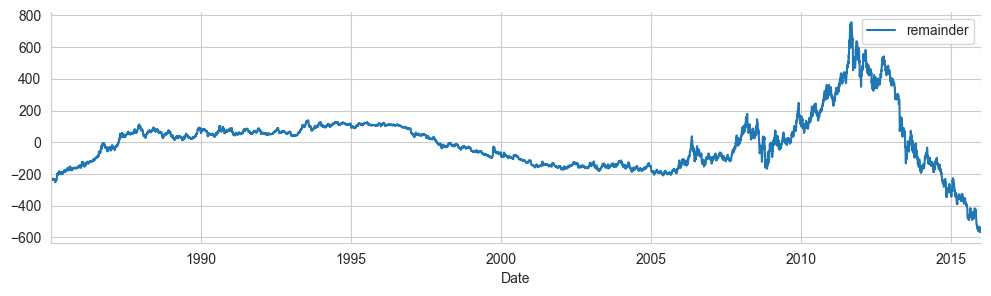

In [71]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['remainder'].plot(legend=True)
sns.despine()

In [72]:
qcd_variance(train['remainder'])

quartile coefficient of dispersion: 0.877584


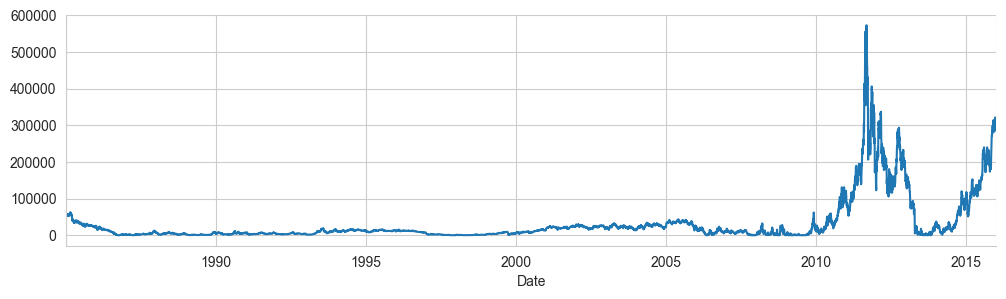

In [73]:
mpl.rc('figure',figsize=(12,3),dpi=100)
(train['remainder']**2).plot()
sns.despine()

In [74]:
qcd_variance(train['remainder'])

quartile coefficient of dispersion: 0.877584


In [75]:
train

,USD,EUR,GBP,INR,AED,CNY,year,time_index,trend,detrended,month,seasonality,trend_seasonal,remainder
Date,,,,,,,,,,,,,,
1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.80,1985,0,530.237229,-231.987229,1,8.859847,539.097076,-240.847076
1985-01-08,302.00,395.32,263.07,3820.70,1114.06,853.01,1985,1,530.026504,-228.026504,1,8.859847,538.886352,-236.886352
1985-01-09,300.50,393.54,263.14,3742.23,1097.47,840.31,1985,2,529.815866,-229.315866,1,8.859847,538.675713,-238.175713
1985-01-10,303.80,397.63,268.02,3853.39,1126.83,862.79,1985,3,529.605313,-225.805313,1,8.859847,538.465160,-234.665160
1985-01-11,304.25,398.60,270.57,3845.57,1135.85,869.69,1985,4,529.394846,-225.144846,1,8.859847,538.254693,-234.004693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-25,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8079,1626.517099,-558.267099,12,-7.456732,1619.060367,-550.810367
2015-12-28,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8080,1626.999299,-558.749299,12,-7.456732,1619.542567,-551.292567
2015-12-29,1070.10,978.87,722.70,70925.69,3930.48,6936.07,2015,8081,1627.481585,-557.381585,12,-7.456732,1620.024853,-549.924853


In [76]:
def create_lagged_features(df, number_of_lags):
    """"""
    df = df[['remainder']]
    
    lags = list(range(1, number_of_lags+1))
    
    for lag in lags:
        column_name = 'lag_' + str(lag)
        df[column_name] = df['remainder'].shift(lag)
        
    return df

In [77]:
p = 3

In [78]:
df = create_lagged_features(train, p)

In [79]:
df.head()

,remainder,lag_1,lag_2,lag_3
Date,,,,
1985-01-07,-240.847076,NaN,NaN,NaN
1985-01-08,-236.886352,-240.847076,NaN,NaN
1985-01-09,-238.175713,-236.886352,-240.847076,NaN
1985-01-10,-234.665160,-238.175713,-236.886352,-240.847076
1985-01-11,-234.004693,-234.665160,-238.175713,-236.886352


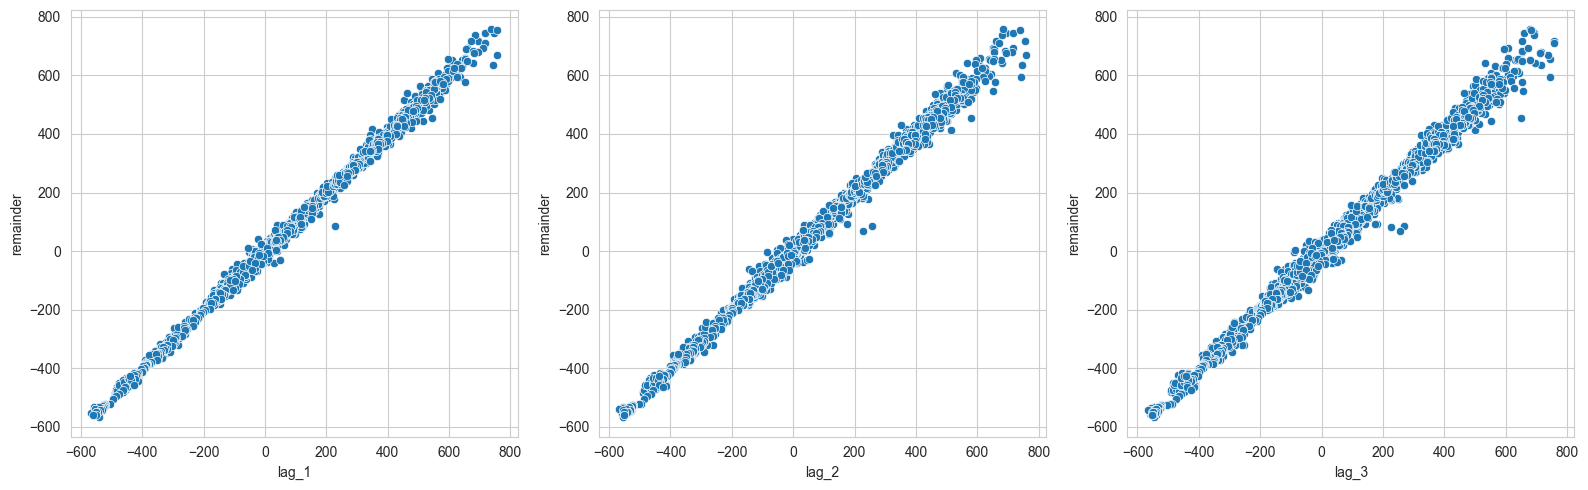

In [80]:
import matplotlib.gridspec as gridspec

lag_columns = df.columns[-p:]
fig, axes = plt.subplots(1,p, figsize=(16,5),dpi=100)
gs = gridspec.GridSpec(1,p)

for i in range(p):
    sns.scatterplot(
        x=df[lag_columns[i]],
        y=df['remainder'],
        ax=axes[i]
    )
    
plt.tight_layout()

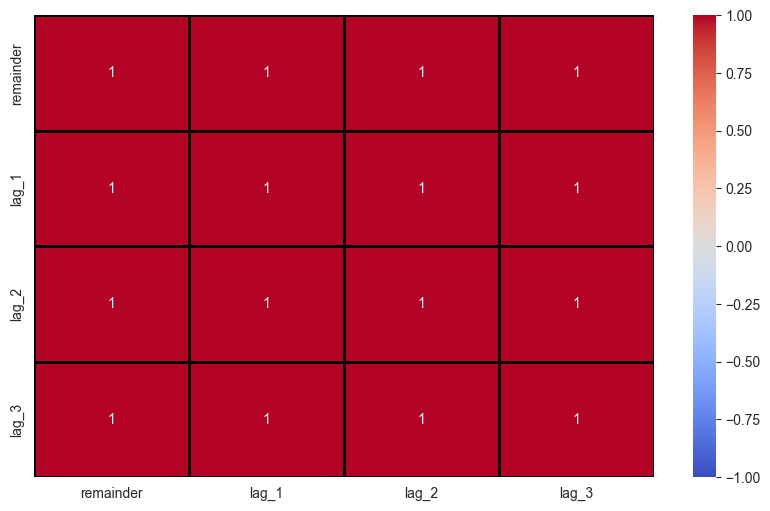

In [81]:
plt.rcParams['figure.figsize'] = (10,6)
sns.heatmap(round(df.corr(),2), 
            cmap = "coolwarm",
            linecolor='black', 
            linewidth=1, 
            annot=True,
            vmin=-1, 
            vmax=1
           );

In [82]:
df.dropna(inplace=True)
df.head()

,remainder,lag_1,lag_2,lag_3
Date,,,,
1985-01-10,-234.665160,-238.175713,-236.886352,-240.847076
1985-01-11,-234.004693,-234.665160,-238.175713,-236.886352
1985-01-14,-239.044311,-234.004693,-234.665160,-238.175713
1985-01-15,-236.034016,-239.044311,-234.004693,-234.665160
1985-01-16,-234.923806,-236.034016,-239.044311,-234.004693


In [83]:
X_remainder = df.drop('remainder',axis=1)
y_remainder = df['remainder']

In [84]:
ar_model = LinearRegression()
ar_model.fit(X_remainder,y_remainder)

LinearRegression()

In [85]:
df['ar_predictions'] = ar_model.predict(X_remainder)

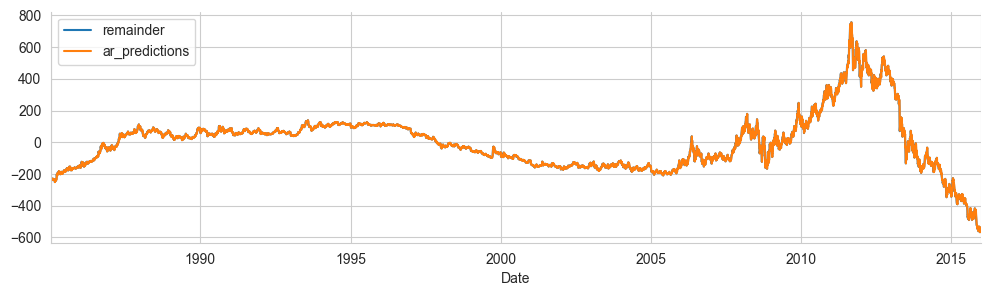

In [86]:
mpl.rc('figure',figsize=(12,3),dpi=100)

df[['remainder','ar_predictions']].plot(legend=True)
sns.despine()

In [87]:
!pip install statsmodels

In [88]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

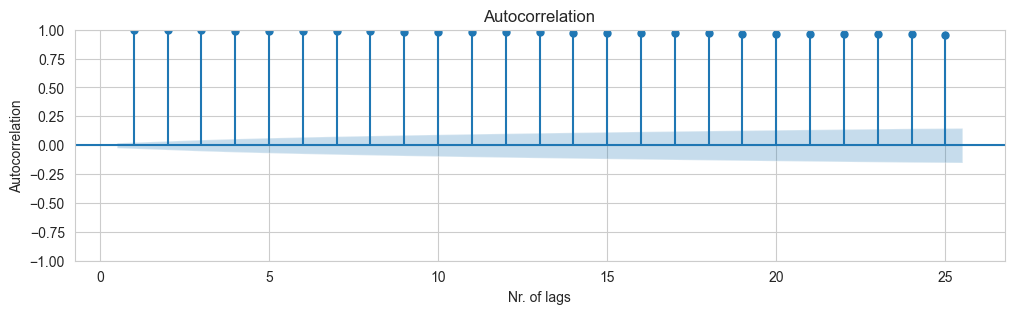

In [89]:
plt.rcParams["figure.dpi"] = 100
plot_acf(df['remainder'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation');

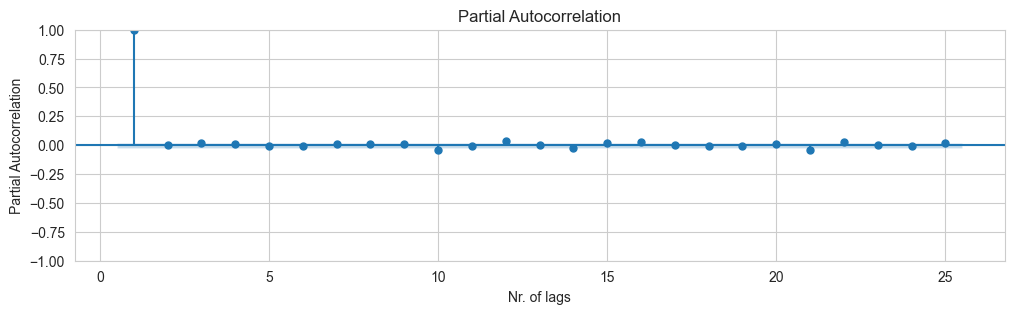

In [90]:
plot_pacf(df['remainder'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation');

In [91]:
df['residuals_ar'] = df['remainder'] - df['ar_predictions']

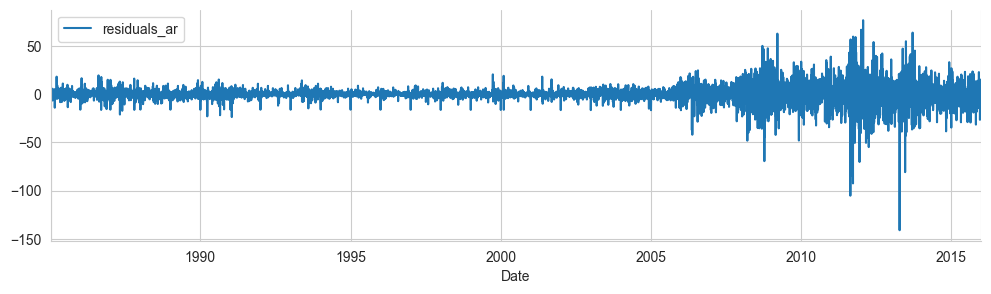

In [92]:
mpl.rc('figure',figsize=(12,3),dpi=100)

df['residuals_ar'].plot(legend=True)
sns.despine()

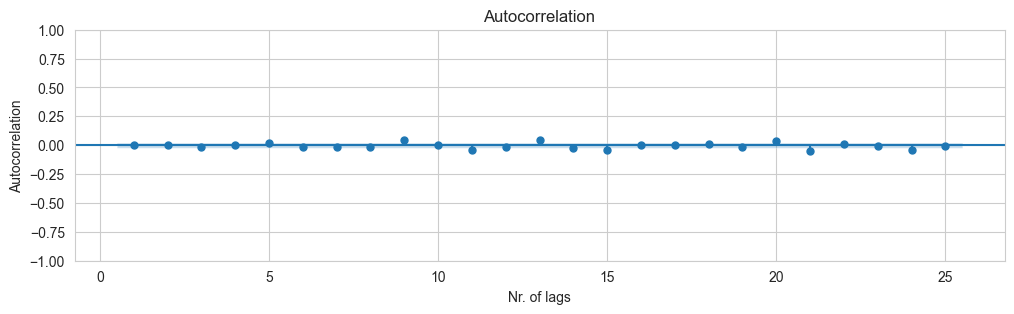

In [93]:
plot_acf(df['residuals_ar'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation');

In [94]:
df['timestep'] = list(range(df.shape[0]))

In [95]:
df.tail()

,remainder,lag_1,lag_2,lag_3,ar_predictions,residuals_ar,timestep
Date,,,,,,,
2015-12-25,-550.810367,-550.328252,-549.846223,-542.714281,-549.891168,-0.919198,8076
2015-12-28,-551.292567,-550.810367,-550.328252,-549.846223,-550.498792,-0.793775,8077
2015-12-29,-549.924853,-551.292567,-550.810367,-550.328252,-550.980692,1.055839,8078
2015-12-30,-560.507224,-549.924853,-551.292567,-550.810367,-549.627528,-10.879696,8079
2015-12-31,-560.989682,-560.507224,-549.924853,-551.292567,-560.149819,-0.839863,8080


In [96]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder
)

In [97]:
col_transformer = ColumnTransformer([
    ('poly', PolynomialFeatures(degree=2), ['timestep']),
    ('ohe', OneHotEncoder(drop='first'), ['month'])
])

In [98]:
baseline_model = make_pipeline(
    col_transformer,
    LinearRegression()
)

In [99]:
train['timestep'] = train.index.month
train

,USD,EUR,GBP,INR,AED,CNY,year,time_index,trend,detrended,month,seasonality,trend_seasonal,remainder,timestep
Date,,,,,,,,,,,,,,,
1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.80,1985,0,530.237229,-231.987229,1,8.859847,539.097076,-240.847076,1
1985-01-08,302.00,395.32,263.07,3820.70,1114.06,853.01,1985,1,530.026504,-228.026504,1,8.859847,538.886352,-236.886352,1
1985-01-09,300.50,393.54,263.14,3742.23,1097.47,840.31,1985,2,529.815866,-229.315866,1,8.859847,538.675713,-238.175713,1
1985-01-10,303.80,397.63,268.02,3853.39,1126.83,862.79,1985,3,529.605313,-225.805313,1,8.859847,538.465160,-234.665160,1
1985-01-11,304.25,398.60,270.57,3845.57,1135.85,869.69,1985,4,529.394846,-225.144846,1,8.859847,538.254693,-234.004693,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-25,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8079,1626.517099,-558.267099,12,-7.456732,1619.060367,-550.810367,12
2015-12-28,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8080,1626.999299,-558.749299,12,-7.456732,1619.542567,-551.292567,12
2015-12-29,1070.10,978.87,722.70,70925.69,3930.48,6936.07,2015,8081,1627.481585,-557.381585,12,-7.456732,1620.024853,-549.924853,12


In [100]:
train

,USD,EUR,GBP,INR,AED,CNY,year,time_index,trend,detrended,month,seasonality,trend_seasonal,remainder,timestep
Date,,,,,,,,,,,,,,,
1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.80,1985,0,530.237229,-231.987229,1,8.859847,539.097076,-240.847076,1
1985-01-08,302.00,395.32,263.07,3820.70,1114.06,853.01,1985,1,530.026504,-228.026504,1,8.859847,538.886352,-236.886352,1
1985-01-09,300.50,393.54,263.14,3742.23,1097.47,840.31,1985,2,529.815866,-229.315866,1,8.859847,538.675713,-238.175713,1
1985-01-10,303.80,397.63,268.02,3853.39,1126.83,862.79,1985,3,529.605313,-225.805313,1,8.859847,538.465160,-234.665160,1
1985-01-11,304.25,398.60,270.57,3845.57,1135.85,869.69,1985,4,529.394846,-225.144846,1,8.859847,538.254693,-234.004693,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-25,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8079,1626.517099,-558.267099,12,-7.456732,1619.060367,-550.810367,12
2015-12-28,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8080,1626.999299,-558.749299,12,-7.456732,1619.542567,-551.292567,12
2015-12-29,1070.10,978.87,722.70,70925.69,3930.48,6936.07,2015,8081,1627.481585,-557.381585,12,-7.456732,1620.024853,-549.924853,12


In [101]:
X_train_baseline = train[['timestep','month']]
y_train = train['USD']

In [102]:
baseline_model.fit(X_train_baseline, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('poly', PolynomialFeatures(),
                                                  ['timestep']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['month'])])),
                ('linearregression', LinearRegression())])

In [103]:
train['trend_seasonal'] = baseline_model.predict(X_train_baseline)

In [104]:
train[['USD','trend_seasonal']].tail()

,USD,trend_seasonal
Date,,
2015-12-25,1068.25,623.26559
2015-12-28,1068.25,623.26559
2015-12-29,1070.10,623.26559
2015-12-30,1060.00,623.26559
2015-12-31,1060.00,623.26559


In [105]:
train['remainder'] = train['USD'] - train['trend_seasonal']

In [106]:
def create_lagged_features(df, number_of_lags):
    """"""
    df = df.copy()
    
    lags = list(range(1, number_of_lags+1))
    
    for lag in lags:
        column_name = 'lag_' + str(lag)
        df[column_name] = df['remainder'].shift(lag)
        
    return df

In [107]:
p = 1

In [108]:
train = create_lagged_features(train, number_of_lags=p)

In [109]:
train[train.columns[-p-1:]].head()

,timestep,lag_1
Date,,
1985-01-07,1,NaN
1985-01-08,1,-307.807354
1985-01-09,1,-304.057354
1985-01-10,1,-305.557354
1985-01-11,1,-302.257354


In [110]:
train.dropna(inplace=True)

In [111]:
X_remainder = train[train.columns[-p:]]
y_remainder = train['remainder']

In [112]:
ar_model = LinearRegression()
ar_model.fit(X_remainder,y_remainder)

LinearRegression()

In [113]:
train['remainder_pred'] = ar_model.predict(X_remainder)

In [114]:
train['total_pred'] = \
train['trend_seasonal'] + train['remainder_pred']

In [115]:
train[['USD','trend_seasonal','total_pred']].tail()

,USD,trend_seasonal,total_pred
Date,,,
2015-12-25,1068.25,623.26559,1068.263929
2015-12-28,1068.25,623.26559,1068.263929
2015-12-29,1070.10,623.26559,1068.263929
2015-12-30,1060.00,623.26559,1070.113604
2015-12-31,1060.00,623.26559,1060.015379


In [116]:
train

,USD,EUR,GBP,INR,AED,CNY,year,time_index,trend,detrended,month,seasonality,trend_seasonal,remainder,timestep,lag_1,remainder_pred,total_pred
Date,,,,,,,,,,,,,,,,,,
1985-01-08,302.00,395.32,263.07,3820.70,1114.06,853.01,1985,1,530.026504,-228.026504,1,8.859847,606.057354,-304.057354,1,-307.807354,-307.661177,298.396177
1985-01-09,300.50,393.54,263.14,3742.23,1097.47,840.31,1985,2,529.815866,-229.315866,1,8.859847,606.057354,-305.557354,1,-304.057354,-303.911836,302.145518
1985-01-10,303.80,397.63,268.02,3853.39,1126.83,862.79,1985,3,529.605313,-225.805313,1,8.859847,606.057354,-302.257354,1,-305.557354,-305.411572,300.645782
1985-01-11,304.25,398.60,270.57,3845.57,1135.85,869.69,1985,4,529.394846,-225.144846,1,8.859847,606.057354,-301.807354,1,-302.257354,-302.112152,303.945202
1985-01-14,299.00,395.39,269.13,3790.08,1109.51,859.68,1985,5,529.184464,-230.184464,1,8.859847,606.057354,-307.057354,1,-301.807354,-301.662231,304.395123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-25,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8079,1626.517099,-558.267099,12,-7.456732,623.265590,444.984410,12,444.984410,444.998339,1068.263929
2015-12-28,1068.25,981.67,717.96,70542.42,3923.68,6917.77,2015,8080,1626.999299,-558.749299,12,-7.456732,623.265590,444.984410,12,444.984410,444.998339,1068.263929
2015-12-29,1070.10,978.87,722.70,70925.69,3930.48,6936.07,2015,8081,1627.481585,-557.381585,12,-7.456732,623.265590,446.834410,12,444.984410,444.998339,1068.263929


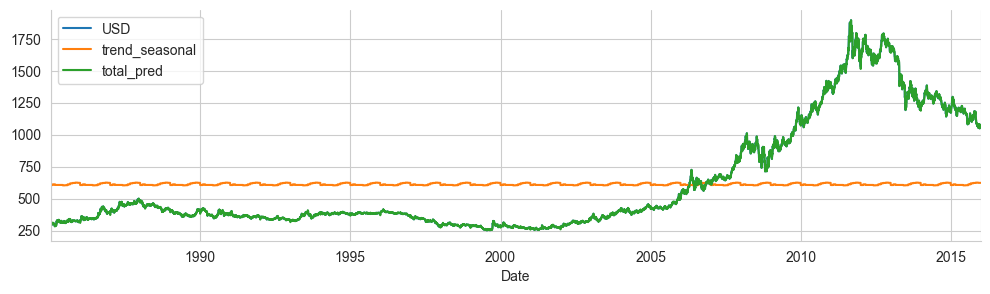

In [117]:
mpl.rc('figure',figsize=(12,3),dpi=100)
train[['USD','trend_seasonal','total_pred']].plot(legend=True)
sns.despine()

In [118]:
r2_ts = round(baseline_model.score(X_train_baseline,y_train),6)
print(f"r2_score: {r2_ts}")

r2_score: 0.000327
